In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
%load_ext autoreload
%autoreload 2

In [13]:
import sys
sys.path.insert(1, './utilities/')

from utility_functions import *

In [14]:
# Loaded a set of images
root_dir = "../../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


In [86]:
path1 = "../saved_data/test_image_29"
whole_img = load_image(path1 + ".png")
whole_img_no_blob = load_image(path1 + "_no_blob" + ".png")

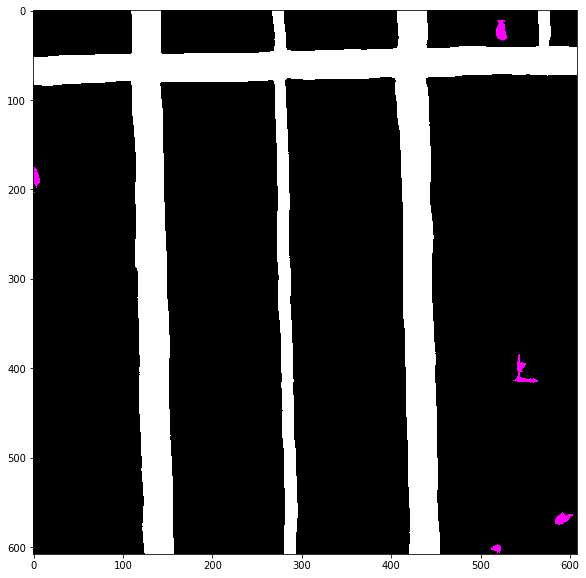

In [87]:
# Show first image and its groundtruth image
cimg = whole_img - whole_img_no_blob
stacked_img = np.stack((cimg,)*3, axis=-1)
whole_img_no_blob = np.stack((whole_img_no_blob,)*3, axis=-1)
cimg[cimg > 0.1] == 204
stacked_img[:,:,0] = cimg
stacked_img[:,:,1] = np.zeros(cimg.shape)
stacked_img[:,:,2] = cimg

stacked_img = stacked_img + whole_img_no_blob
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(stacked_img)
plt.savefig("w_wo_blob.png")

Image size = (400, 400, 3),400


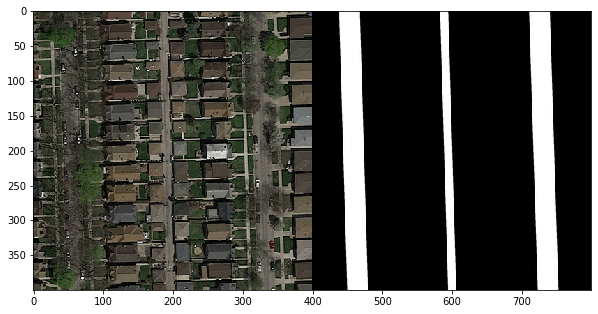

In [18]:
print('Image size = ' + str(imgs[0].shape) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [28]:
# Extract patches from all the input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [19]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 2
Number of classes = 1
Class 0: 4915 samples
Class 1: 1335 samples


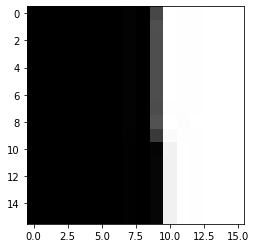

In [21]:
# Display a patch that belongs to the foreground class
#plt.imshow(gt_patches[Y1[8]], cmap='Greys_r')
plt.imshow(gt_patches[Y1[6]], cmap='Greys_r')

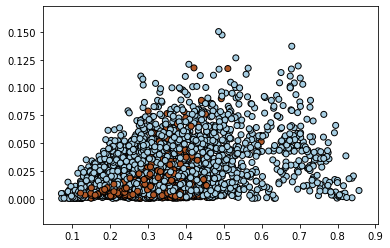

In [22]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [23]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced",solver='liblinear',penatly='l1')
logreg.fit(X, Y)

/Users/jerome/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.15056


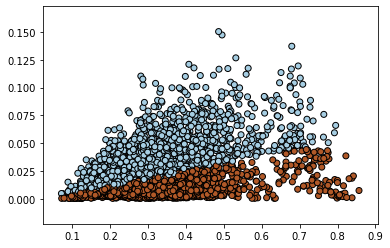

In [25]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [56]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.45)
    return new_img
    

In [53]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx],patch_size)
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

KeyboardInterrupt: 

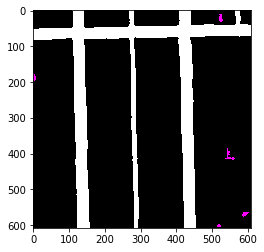

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(608, 608, 3) (608, 608, 3)
(608, 608, 3) (608, 608, 4)


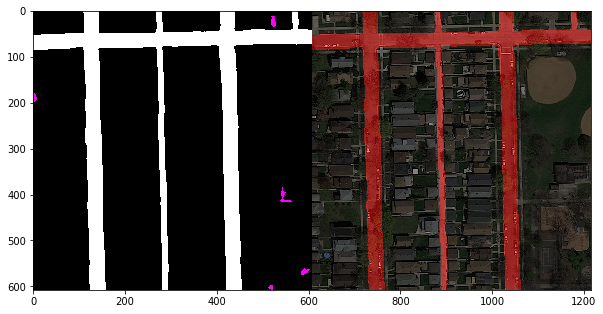

In [94]:
# Display prediction as an image
w_wo_blob = load_image("w_wo_blob.png")
test_normal = load_image("test_29.png")
test_predict =  load_image(path1 + "_no_blob" + ".png")

plt.imshow(stacked_img)
plt.show()

print(stacked_img.shape, test_normal.shape)
new_img = make_img_overlay(test_normal, test_predict)
print(stacked_img.shape, np.asarray(new_img).shape)

new_img2 = make_img_overlay(stacked_img, np.zeros((608,608)))
stacked_img2 = np.concatenate((stacked_img,np.zeros((608,608,1))), axis=-1)
res = np.concatenate((new_img2,np.divide(new_img,255)), axis=1)

fig1 = plt.figure(figsize=(10, 10))
plt.imshow(res, cmap='Greys_r')
plt.savefig("concat_blob.png")
plt.show()